In [ ]:
#@markdown # Imports
#!uv pip install xmltodict html-to-markdown[lxml,html5lib] seaborn

import os
import time
import json
import pickle
import requests
import xmltodict
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.cli import tqdm
from bs4 import BeautifulSoup
from multiprocessing import Pool
from urllib.parse import urljoin, urlencode
from html_to_markdown import convert_to_markdown
from IPython.display import Markdown, display
from google.colab import userdata
from typing import Literal, List, Optional
from pydantic import BaseModel, Field
from openai import OpenAI
import hashlib
from pathlib import Path

os.chdir('/projects/moties')

if 'api_key' not in globals():
  api_key = userdata.get('RUGLLM')
base_url="https://llm.hpc.rug.nl/v1"

check_cache = True #@param {"type": "boolean"}

client = OpenAI(api_key=api_key, base_url=base_url)

model='mistralai/Mistral-Small-3.2-24B-Instruct-2506'

CACHE_DIR = Path(".cache_responses")
CACHE_DIR.mkdir(exist_ok=True)


In [ ]:
with open('decision_data.p3', 'rb') as f:
  data = pickle.load(f)
besluiten = data['besluiten']
zaken = data['zaken']
documenten = data['documenten']
versies = data['versies']
stemmen = data['stemmen']
texts = data['texts']
zaken_ = zaken.set_index('Id')[[
  'Nummer', 'Soort', 'Titel', 'Citeertitel', 'Alias', 'Onderwerp', 'GestartOp',
  'Organisatie', 'Grondslagvoorhang', 'Termijn', 'Vergaderjaar', 'Volgnummer',
  'HuidigeBehandelstatus', 'Afgedaan']]

responses = {}
for fn in os.listdir(CACHE_DIR):
  with open(CACHE_DIR / fn) as f:
    data = json.load(f)
    text = data['messages'][1]['content']
    try:
      response = json.loads(data['response'])
      responses[text] = response
    except json.JSONDecodeError: pass
responses = texts.apply(responses.get).apply(pd.Series)

In [ ]:
party_selection = ['JA21', 'Volt', 'FVD', 'DENK', 'PvdD', 'SGP', 'ChristenUnie', 'SP', 'CDA', 'BBB', 'D66', 'NSC', 'VVD', 'GroenLinks-PvdA', 'PVV']

stemmen_ = stemmen.reset_index('Besluit_Id', drop=True).loc[responses.index]

stance_columns = ['economic_cost_impact', 'environment_impact', 'fiscal_tag', 'healthcare_impact', 'rights_impact', 'security_impact', 'social_security_impact']



party_stances = pd.DataFrame([
    dict(**metadata[['topic', 'beneficiaries_of_vote_in_favor', 'beneficiaries_of_vote_against', 'summary_of_decision', 'notes']], **zaken_.loc[id], **{
        c: metadata[c + {'Voor': '_of_vote_in_favor', 'Tegen': '_of_vote_against'}.get(stance)] if stance in {'Voor', 'Tegen'} else 'not-participated'
        for c in stance_columns
    }, party=party, stance=stance, count=count) for id, metadata in tqdm(responses.iterrows(), total=len(responses)) for (party, stance), count in stemmen_.loc[id].items() if party in party_selection])

party_stances['party'] = party_stances['party'].replace('GroenLinks', 'GroenLinks-PvdA').replace('PvdA', 'GroenLinks-PvdA')

# IMPORTANT: Remove points which weren't processed by the LLM (due to their document size)
party_stances = party_stances[~party_stances['economic_cost_impact'].isna()].copy()
party_stances = party_stances[~party_stances['summary_of_decision'].isna()].copy()

100%|██████████| 7984/7984 [01:36<00:00, 82.55it/s]


In [ ]:
ps = party_stances

impacts__ = party_stances.query('stance == "Voor"').groupby('Nummer')[stance_columns].first()
impacts__ = impacts__.loc[ps['Nummer'].unique()]

drop_columns = ['Alias', 'Grondslagvoorhang', 'HuidigeBehandelstatus']
separate = [
  'topic', 'beneficiaries_of_vote_in_favor', 'beneficiaries_of_vote_against',
  'summary_of_decision', 'notes', 'Titel', 'Onderwerp', 'Soort', 'Citeertitel',
  'GestartOp', 'Organisatie', 'Termijn', 'Vergaderjaar', 'Volgnummer',
  'Afgedaan']

expanded_columns = [c for c in ps.columns if c not in separate and c not in drop_columns]
metadata = pd.concat([ps.groupby(['Nummer'])[separate].first(), impacts__], axis=1).reset_index()
metadata = {k: v for k, v in metadata.to_dict(orient='split').items() if k in {'columns', 'data'}}

data = {k: v for k, v in ps[expanded_columns].to_dict(orient='split').items() if k in {'columns', 'data'}}
data['data'] = [[None if pd.isna(x) else x for x in x] for x in data['data']]
data['metadata'] = metadata['data']
data['metadata_columns'] = metadata['columns']

with open('party_stances.json', 'w') as f:
  json.dump(data, f)

from google.colab.files import download
download('party_stances.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
impact_vote_counts = party_stances.set_index(['party', 'count'])[[
    'economic_cost_impact', 'environment_impact', 'fiscal_tag', 'healthcare_impact', 'rights_impact', 'security_impact', 'social_security_impact'
]].melt(ignore_index=False).reset_index().groupby(['party', 'variable', 'value'])['count'].sum().rename('count').reset_index().pivot(index=['party', 'value'], columns=['variable'], values='count').fillna(0).astype(int)
impact_vote_percentages = impact_vote_counts.groupby('party').apply(lambda x: 100 * x / x.sum())
impact_vote_counts

variable               economic_cost_impact  environment_impact  fiscal_tag  \
party  value                                                                  
50PLUS budget-neutral                     0                   0           0   
       costs                              0                   0           4   
       expands                            0                   0           0   
       higher                             4                   0           0   
       improves                           0                   4           0   
...                                     ...                 ...         ...   
Volt   neutral                         3094                1523           0   
       restricts                          0                   0           0   
       saves                              0                   0        3054   
       unclear                         2834                 254        1552   
       worsens                            0                 432           0   

variable               healthcare_impact  rights_impact  security_impact  \
party  value                                                               
50PLUS budget-neutral                  0              0                0   
       costs                           0              0                0   
       expands                         0              0                0   
       higher                          0              0                0   
       improves                        0              0                0   
...                                  ...            ...              ...   
Volt   neutral                      4050           6304             7500   
       restricts                       0           1891                0   
       saves                           0              0                0   
       unclear                       118             68              500   
       worsens                       421              0              683   

variable               social_security_impact  
party  value                                   
50PLUS budget-neutral                       0  
       costs                                0  
       expands                              0  
       higher                               0  
       improves                             0  
...                                       ...  
Volt   neutral                           7665  
       restricts                            0  
       saves                                0  
       unclear                            360  
       worsens                            876  

[252 rows x 7 columns]

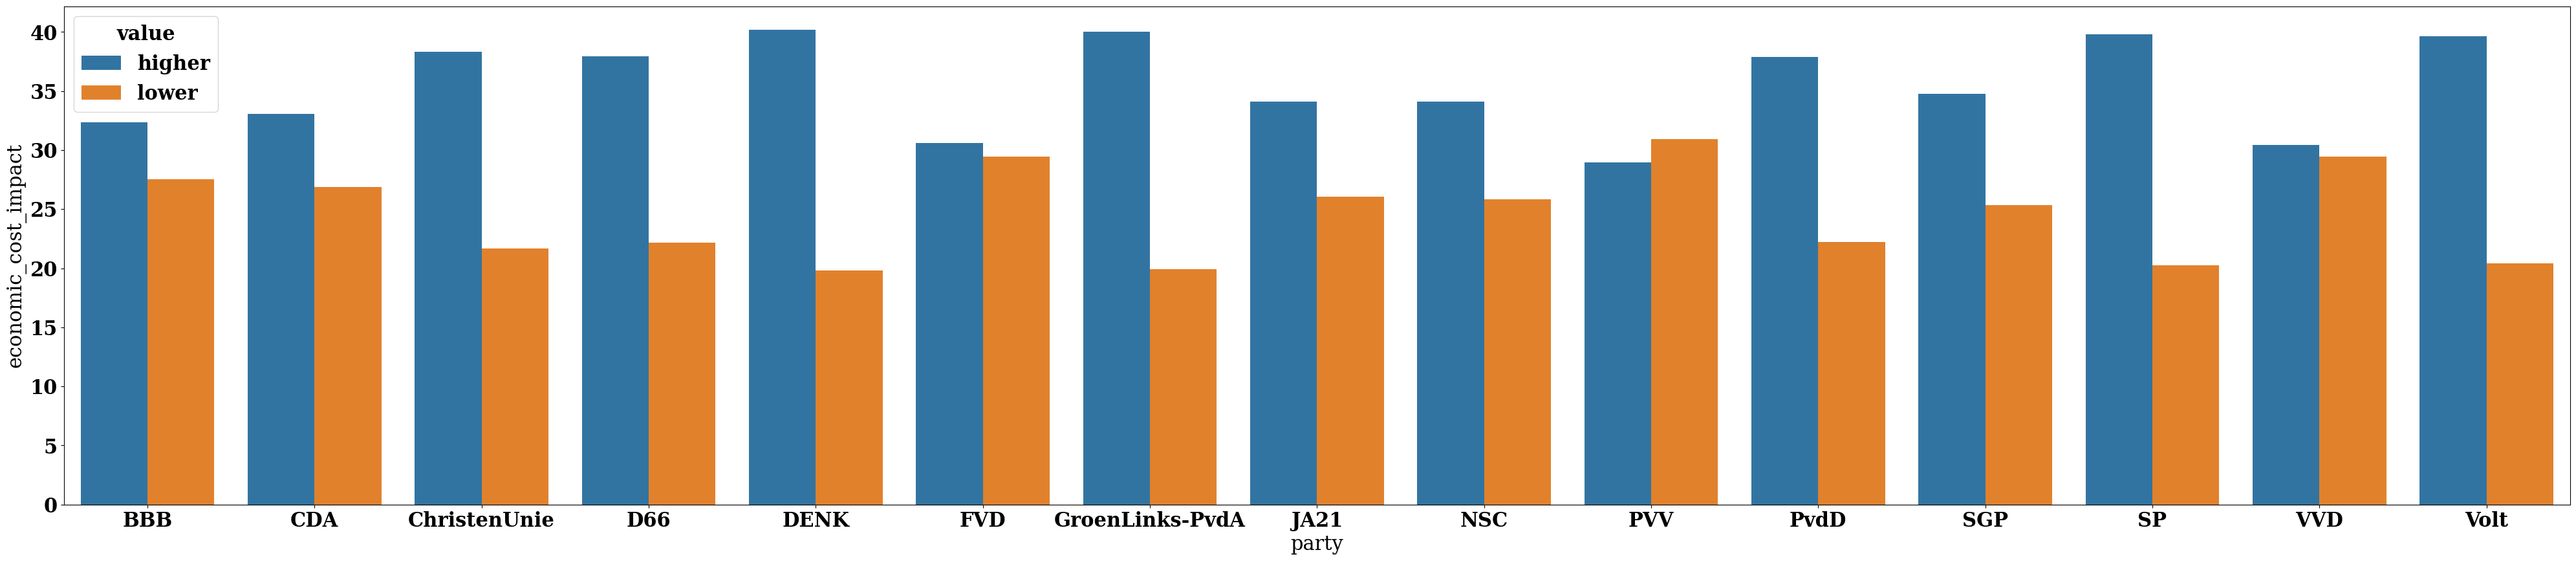

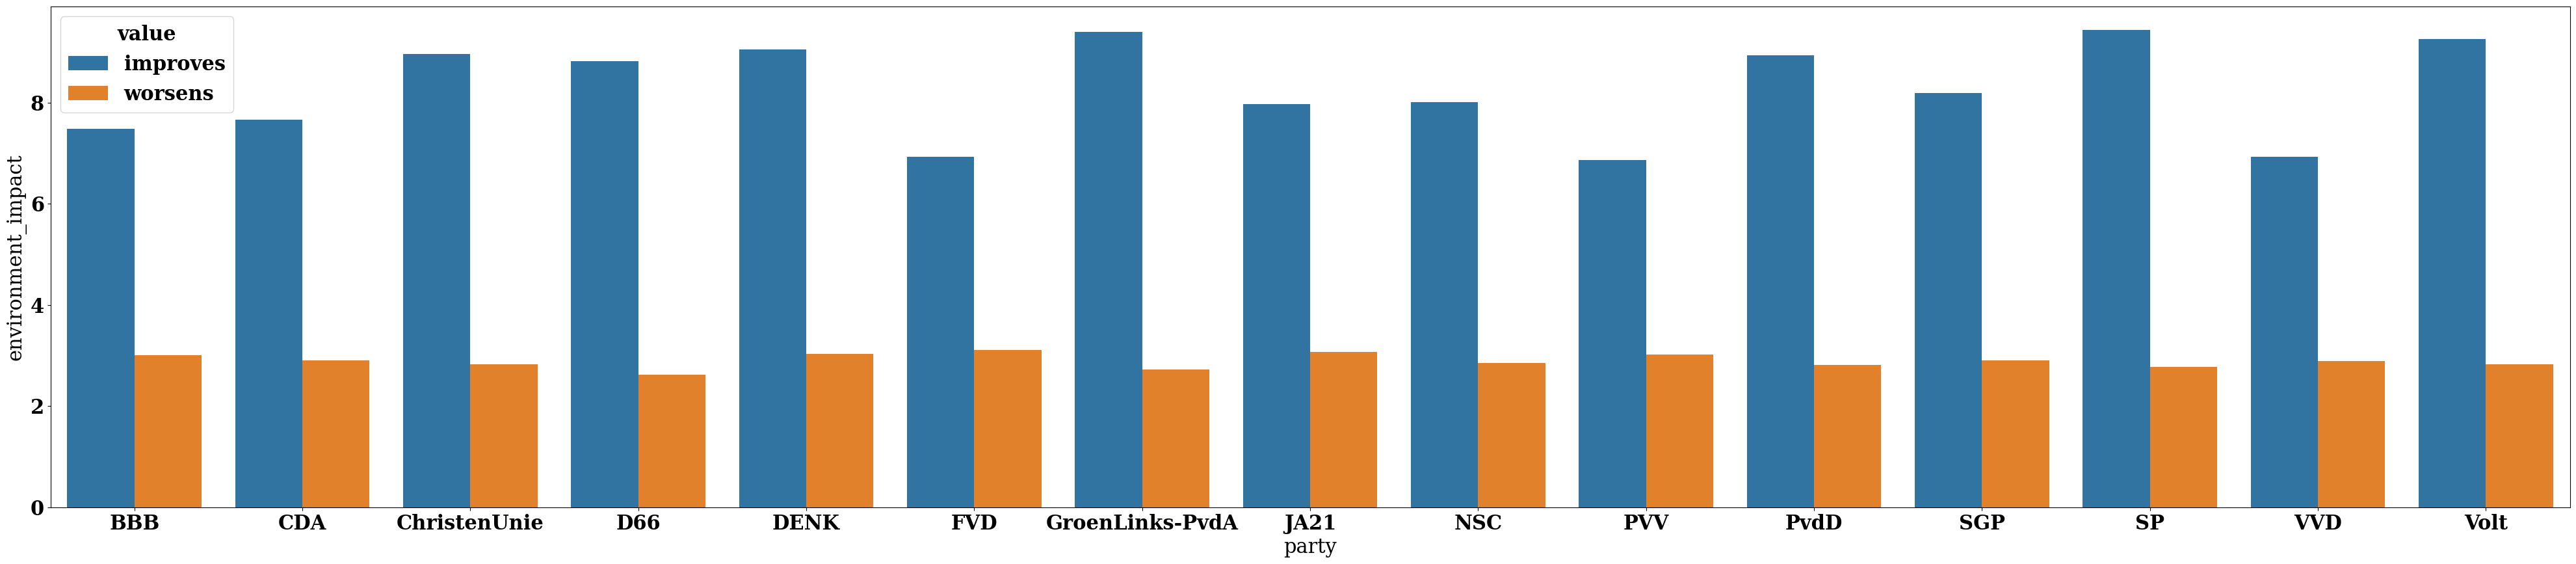

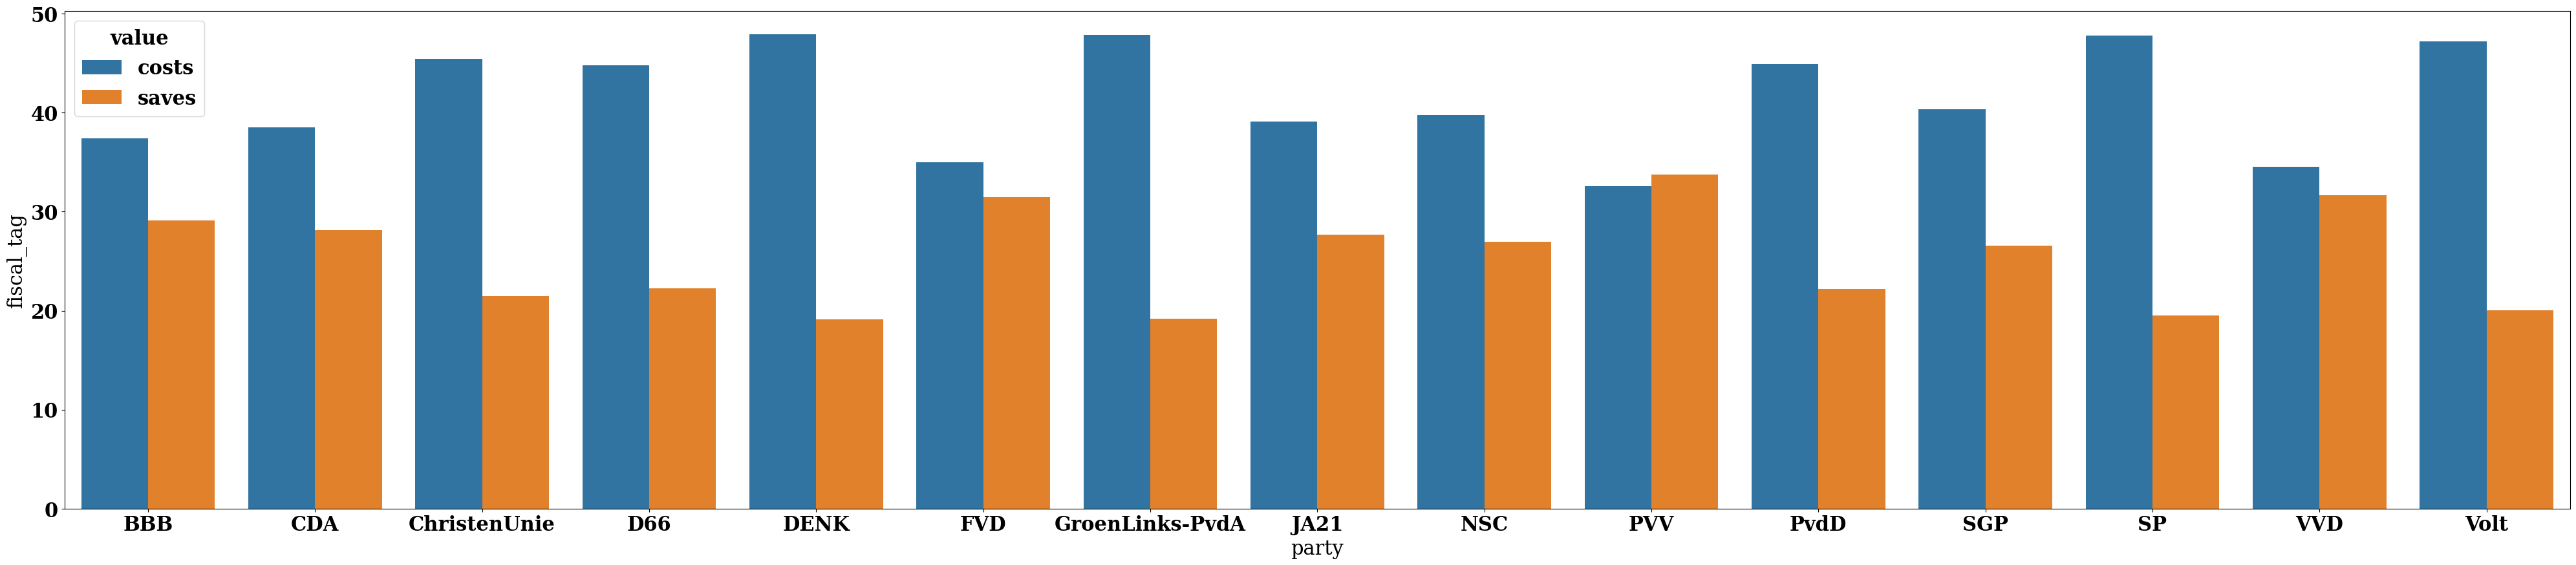

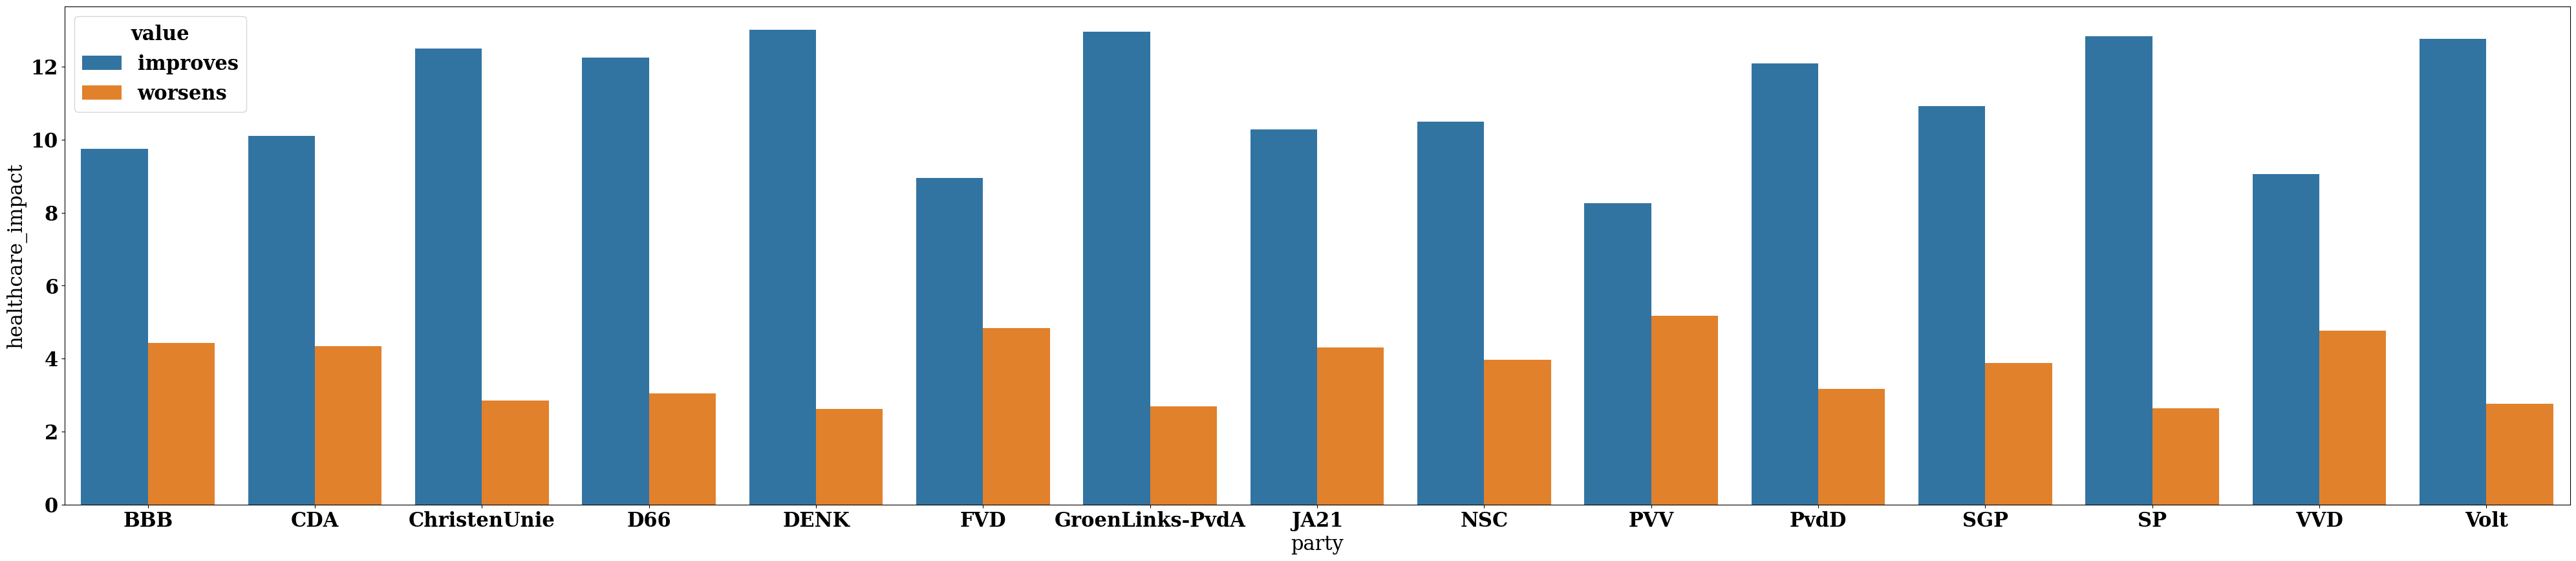

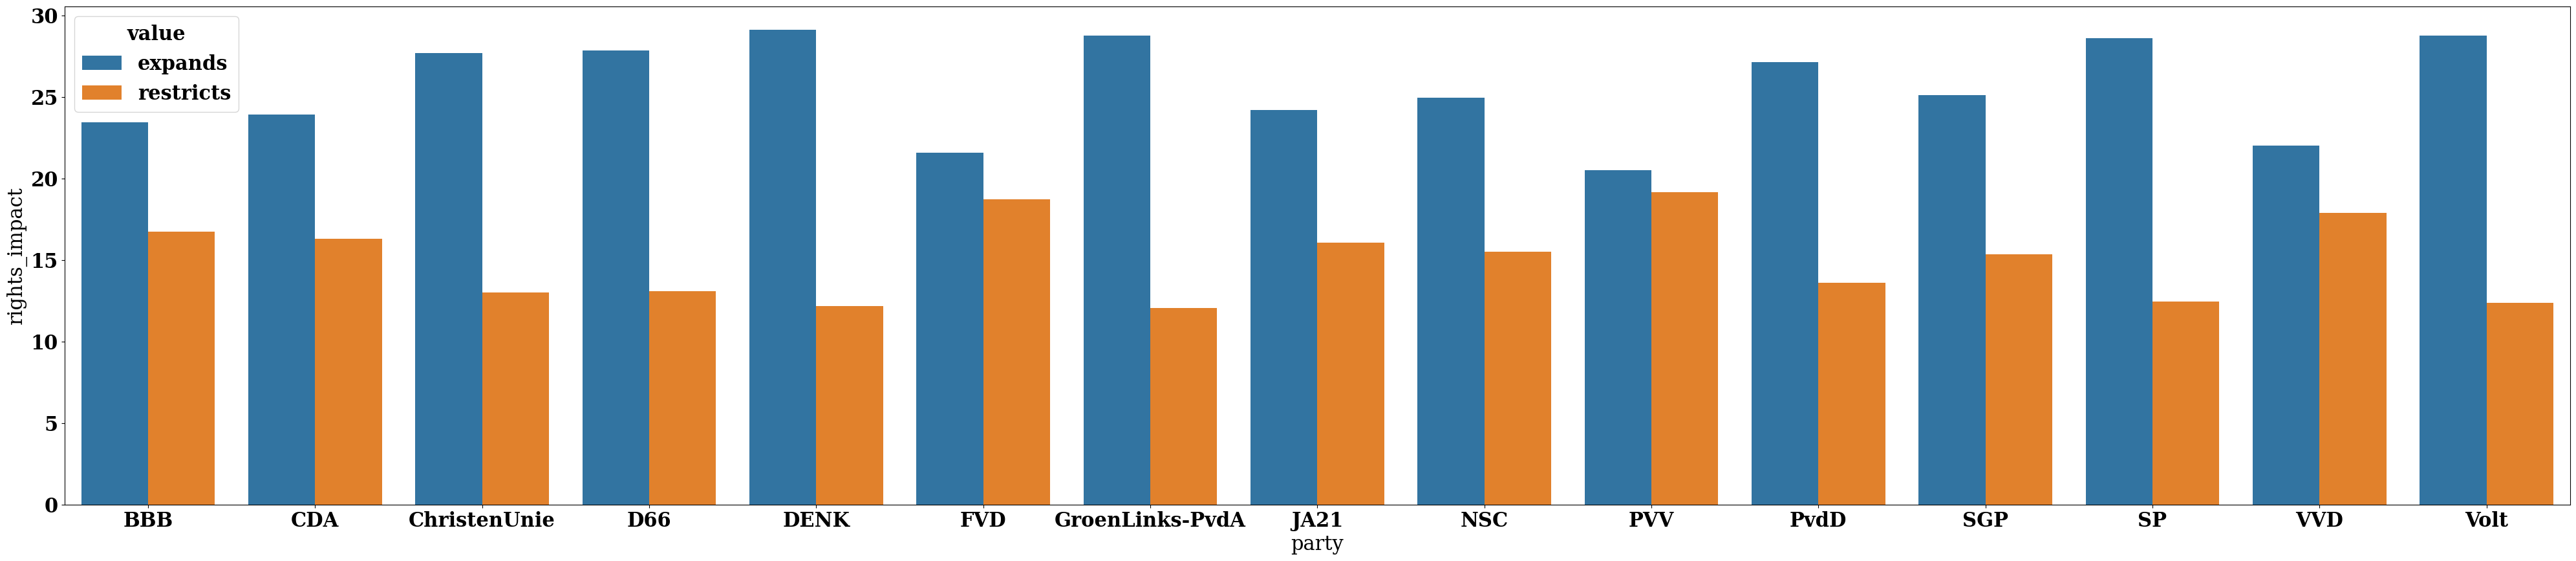

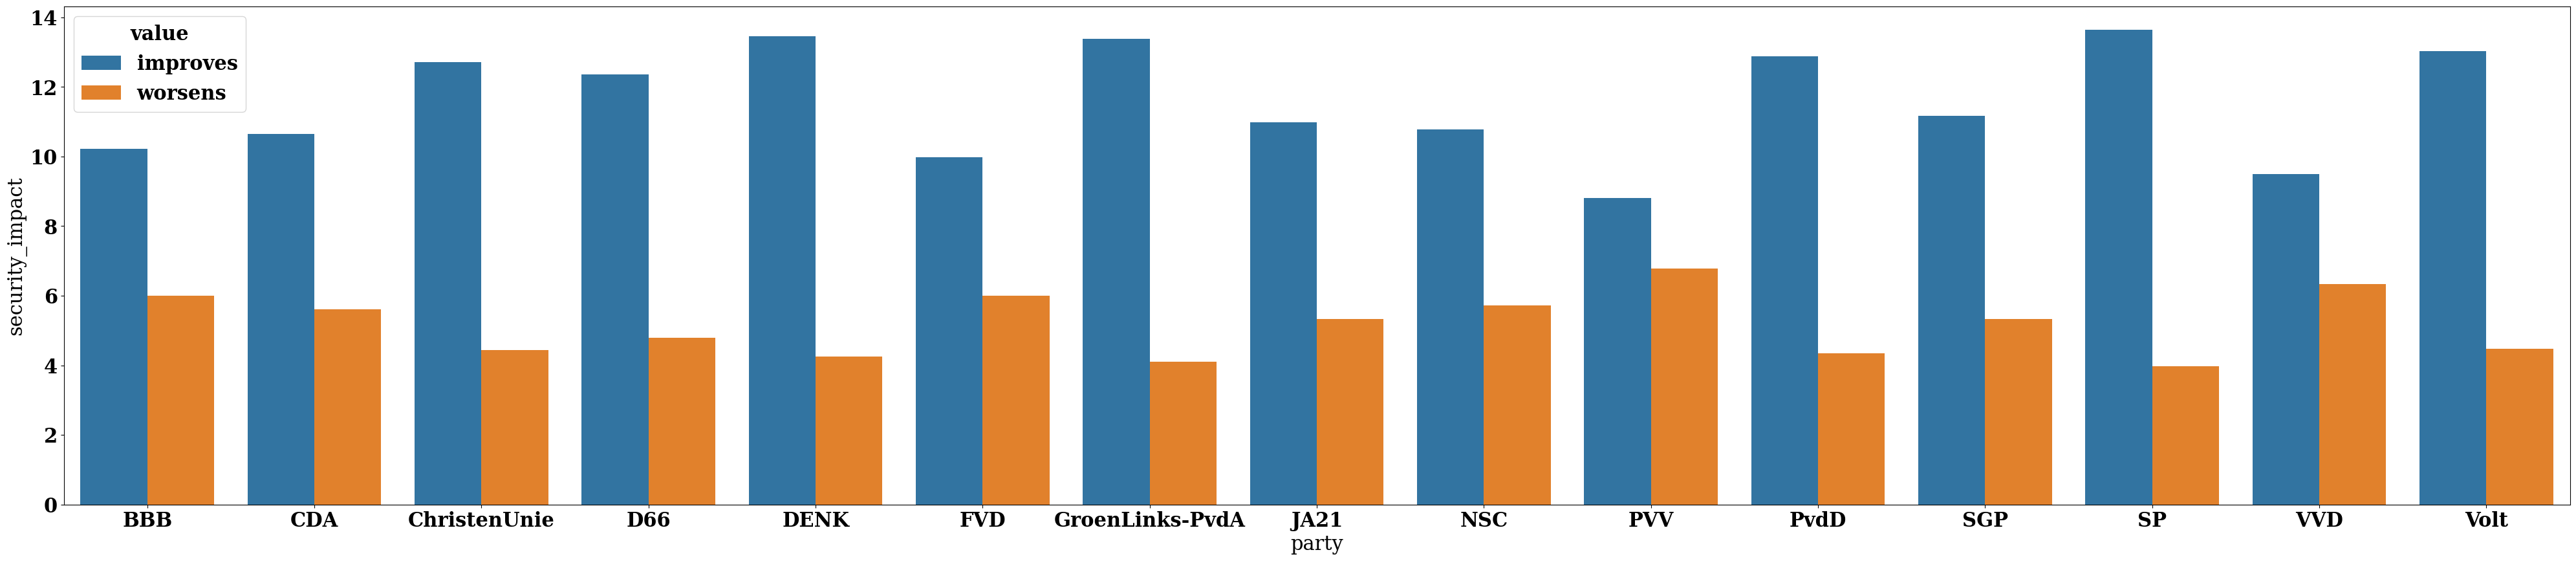

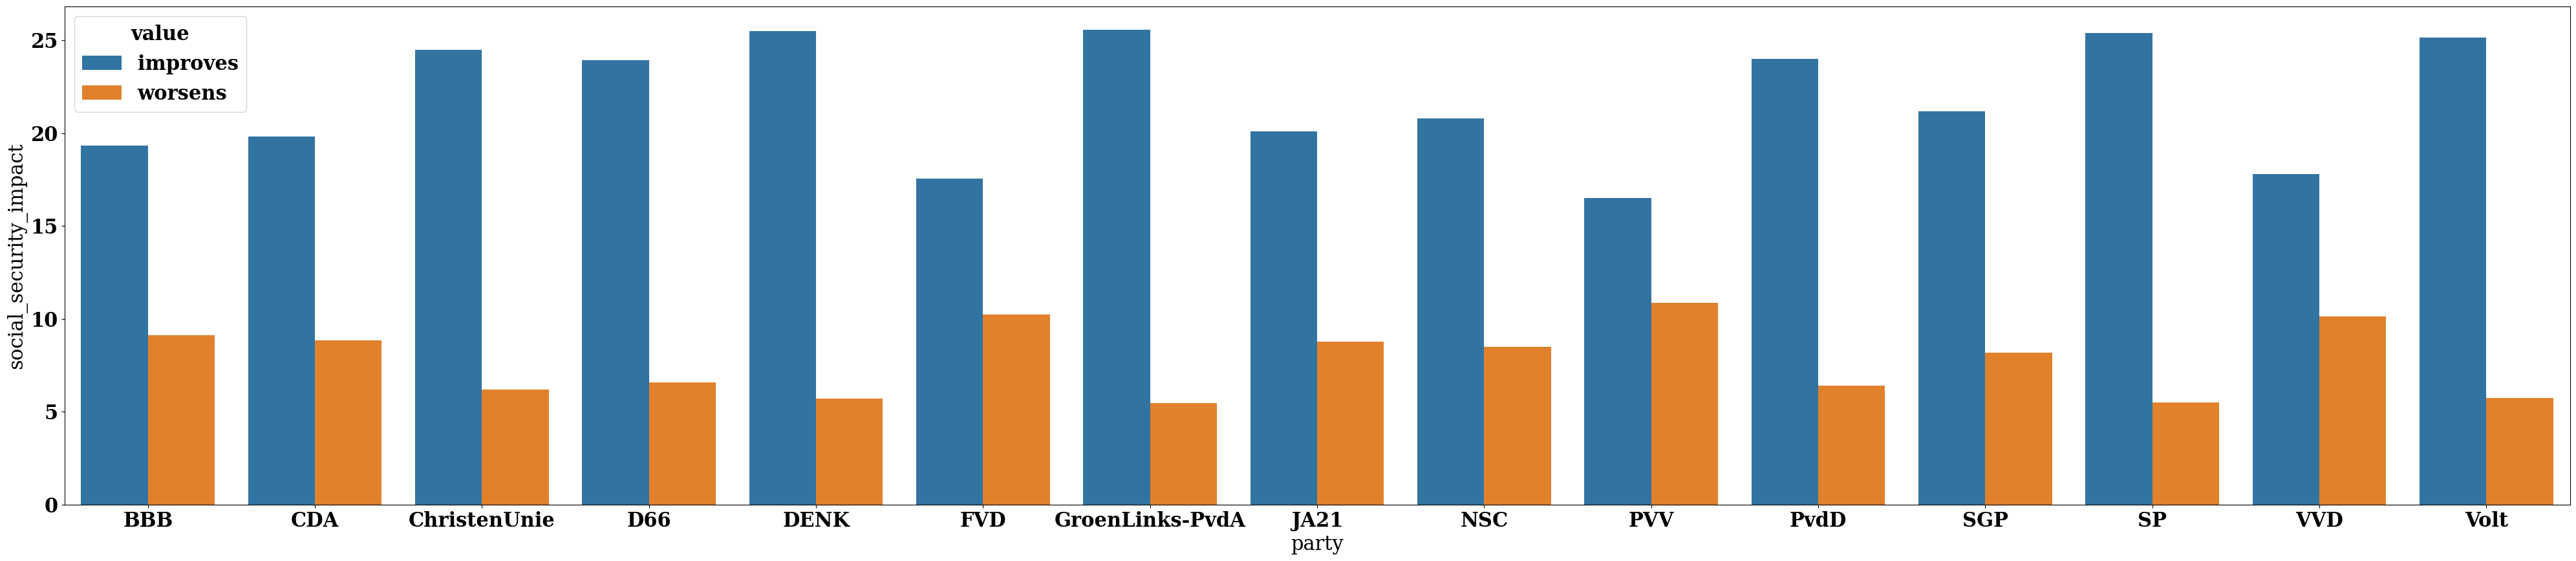

In [ ]:
import seaborn.objects as so
import matplotlib

font = {'family' : 'Serif', 'size': 22}
matplotlib.rc('font', **font)

impacts = ['lower', 'higher', 'costs', 'expands', 'improves', 'restricts', 'saves', 'worsens']
party_selection = ['JA21', 'Volt', 'FVD', 'DENK', 'PvdD', 'SGP', 'ChristenUnie', 'SP',
       'CDA', 'BBB', 'D66', 'NSC', 'VVD', 'GroenLinks-PvdA', 'PVV']


for c in impact_vote_counts.columns:
  relevant_impact_vote_percentages = impact_vote_percentages.loc[party_selection].reset_index(0, drop=True).loc[:, impacts, :].sort_index()
  economy = relevant_impact_vote_percentages[c].reset_index().query(f'{c} > 0')

  plt.figure(figsize=(50, 10))
  sns.barplot(data = economy, hue='value', x='party', y=c)
None

In [ ]:
party_stances.query('party == "PVV" and environment_impact == "improves"').sort_values('count')

,summary_of_decision,notes,economic_cost_impact,environment_impact,fiscal_tag,healthcare_impact,rights_impact,security_impact,social_security_impact,party,stance,count
236960,"Motion urges the government to make agreements with provinces and management organizations for comprehensive, adequate, and uniform monitoring and evaluation of nature quality and underlying ecosystems relative to a reference date, and to inform the parliament about this before the committee debate on Nitrogen, NPLG, and nature.","The motion aims to improve nature quality monitoring and evaluation, which will likely require additional government resources. This could increase economic costs and government spending but would improve environmental outcomes. The fiscal tag for the con vote is 'saves' because rejecting the motion avoids these costs.",higher,improves,costs,n/a,neutral,n/a,neutral,PVV,Voor,0
220009,Motion to remove all national 'gold plating' from Dutch legislation regarding the CSDDD (Corporate Sustainability Due Diligence Directive).,Removing national 'gold plating' from the CSDDD would lower costs for businesses but may worsen environmental and social standards. This could restrict rights and increase overall economic costs for society. The fiscal impact would save the government money as it would not need to enforce additional regulations.,higher,improves,costs,neutral,expands,neutral,improves,PVV,Tegen,0
220812,Motion to ban advertising for ultrafast fashion due to environmental concerns and negative effects on youth.,"Banning ultrafast fashion advertising aims to reduce environmental harm and overconsumption, potentially lowering overall economic costs. The fiscal impact is neutral as the government neither saves nor spends significantly. The motion does not directly affect security, social security, or healthcare.",lower,improves,budget-neutral,neutral,neutral,neutral,neutral,PVV,Voor,0
220856,An amendment to increase the budget for the Subsidieregeling Coöperatieve Energieopwekking (SCE) by €5 million to support energy cooperatives in the energy transition.,"The amendment aims to support energy cooperatives by increasing the budget for the SCE, which is expected to improve environmental outcomes. The fiscal impact is a cost to the government, while rejecting the amendment would save government funds. The economic cost impact is higher for the pro vote due to increased government spending, and lower for the con vote due to reduced government spending.",higher,improves,costs,neutral,neutral,neutral,neutral,PVV,Voor,0
234892,"The motion urges the state secretary to voice concerns to the Milieuraad about lobbying against a PFAS ban, emphasizing the importance of not delaying the ban to prevent increasing societal costs.","The motion aims to protect public health and the environment by preventing delays in a PFAS ban, which could lead to higher societal and healthcare costs. The fiscal impact is unclear due to potential long-term savings from preventing PFAS-related health issues versus immediate costs of enforcement and cleanup.",unclear,improves,costs,improves,neutral,neutral,improves,PVV,Voor,0
...,...,...,...,...,...,...,...,...,...,...,...,...
341548,"The motion asks the government to investigate whether temporary bicycle bridges would be more cost-effective than continuing the use of bicycle buses, given the prolonged closure of the Afsluitdijk's bicycle path due to construction work.","The motion aims to improve sustainability and accessibility for cyclists but may increase government expenditure. The cost impact is higher for the pro vote due to the potential construction of temporary bridges, while the con vote saves by continuing the current, less expensive bicycle bus service. The environmental impact is positive for the pro vote as it promotes cycling, a greener transportation method.",higher,improves,costs,neutral,neutral,neutral,neutral,PVV,Voor,37
350040,"The amendment proposes an exception to allow verduurzamingsmaatregelen 